# Analysis of Output
After running a trial, I move all output to its own directory, e.g. `build/src/trial_smallB_n064`.

- The suffix "`_rev`" indicates that the initial velocity was reversed (equivalent to negating the magnetic field). This is expected to reduce stability.
- The suffix "`_old`" indicates that the initial velocity was miscalculated to be inward along y and outward along z
- The suffix "`_start`" indicates that only t=0 is available
- The suffix "`_fromphi`" indicates that the electric field was calculated from the given potential (otherwise, the trial simply used the given field)
- The prefix "`bug`" indicates that the interpolation was bugged (mixed-up weights)
- The number after `n` (064 above) is the number of grid cells per axis.
- The number after `N` is the number of steps done (`psc_params.nmax`), e.g. 30k. Default is 5k.
- B is the transverse magnetic field, given by the following:

| Size | Value |
| :-   | :-:   |
| small| .1    |
|med   | 1     |
|big   | 10    |

In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import viscid
viscid.calculator.evaluator.enabled = True
from viscid.plot import vpyplot as vlt

import os
import ipywidgets as widgets
from IPython.display import display

%config InlineBackend.figure_format = 'retina'

In [2]:
# where the data is
trialpath="/Users/james/Code/cpp/PSC/psc/build/src"

# which data to use
all_files = os.listdir(trialpath)
valid_trialfiles = sorted([file for file in all_files if "trial_" in file])

if "pfd.xdmf" in all_files:
    valid_trialfiles = ["."] + valid_trialfiles

trialfile = valid_trialfiles[0]

w = widgets.Dropdown(
    options=valid_trialfiles,
    value=trialfile,
    description='Trial file:',
    disabled=False,
)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global trialfile
        trialfile = change['new']

w.observe(on_change)

display(w)

Dropdown(description='Trial file:', options=('.', 'bugtrial_bigB_n064', 'bugtrial_bigB_n064_old', 'bugtrial_bi…

In [49]:
# Load everything

run = f"{trialpath}/{trialfile}/pfd.xdmf"
vf = viscid.load_file(run, force_reload=True)

run_moments = f"{trialpath}/{trialfile}/pfd_moments.xdmf"
vf_moments = viscid.load_file(run_moments, force_reload=True)

run_gauss = f"{trialpath}/{trialfile}/gauss.xdmf"
vf_gauss = viscid.load_file(run_gauss, force_reload=True)

run_phi = f"{trialpath}/{trialfile}/phi.xdmf"
vf_phi = viscid.load_file(run_phi, force_reload=True)

run_grad = f"{trialpath}/{trialfile}/grad.xdmf"
vf_grad = viscid.load_file(run_grad, force_reload=True)

run_divgrad = f"{trialpath}/{trialfile}/divgrad.xdmf"
vf_divgrad = viscid.load_file(run_divgrad, force_reload=True)

## Fields and Current

Trial: .
['jx_ec', 'jy_ec', 'jz_ec', 'ex_ec', 'ey_ec', 'ez_ec', 'hx_fc', 'hy_fc', 'hz_fc']
t = 0.0


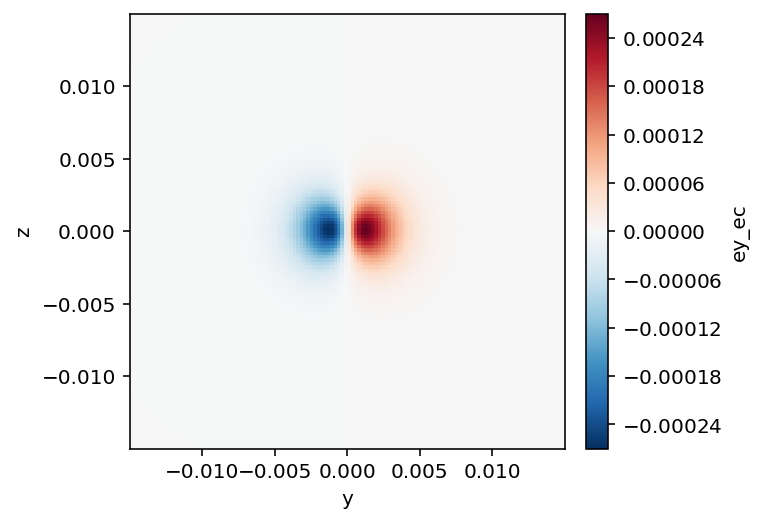

In [50]:
print(f"Trial: {trialfile}")
run = f"{trialpath}/{trialfile}/pfd.xdmf"
vf = viscid.load_file(run, force_reload=True)
print([f.name for f in vf.iter_fields()])

vf.activate_time(0)
# vlt.plot((vf["jz_ec"]**2 + vf["jy_ec"]**2)**.5, cbarlabel="$j$")
# vlt.plot((vf["ey_ec"]**2 + vf["ez_ec"]**2)**.5, cbarlabel="$E$");
# vlt.plot((vf["hy_fc"]**2 + vf["hz_fc"]**2)**.5, cbarlabel = "$H$")
# vlt.plot(vf["hx_fc"])
# vlt.plot(vf["jy_ec"])
vlt.plot(vf["ey_ec"]);
# plt.pcolormesh(vf["ey_ec"].data[0,:,:]);


print(f't = {vf["jx_ec"]._info["time"]}')

## Moments

Trial: .
['rho_e', 'jx_e', 'jy_e', 'jz_e', 'px_e', 'py_e', 'pz_e', 'txx_e', 'tyy_e', 'tzz_e', 'txy_e', 'tyz_e', 'tzx_e', 'rho_i', 'jx_i', 'jy_i', 'jz_i', 'px_i', 'py_i', 'pz_i', 'txx_i', 'tyy_i', 'tzz_i', 'txy_i', 'tyz_i', 'tzx_i']


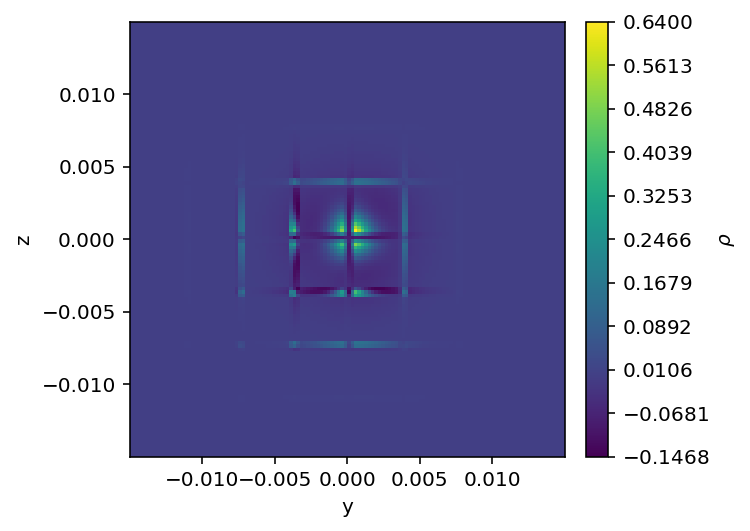

In [52]:
print(f"Trial: {trialfile}")
run_moments = f"{trialpath}/{trialfile}/pfd_moments.xdmf"
vf_moments = viscid.load_file(run_moments, force_reload=True)
print([f.name for f in vf_moments.iter_fields()])

vf_moments.activate_time(0)
vlt.plot(vf_moments["rho_i"] + vf_moments["rho_e"], cbarlabel="$\\rho$");
# vlt.plot((vf_moments["py_e"]**2 + vf_moments["pz_e"]**2)**.5, cbarlabel="$p_e$")
# vlt.plot(vf_moments["tyy_e"] + vf_moments["tzz_e"], cbarlabel = "$T$")
# vlt.plot(vf_moments["rho_e"]);

## Discrepancy in E
The electric field does not precisely satisfy Gauss' law at t=0. Using more grid points decreases the error. It seems that we can bring the error arbitrarily close to 0 in this way. This could be because

1. more of the input txt file (both `ne` and `E`) is used at higher resolution
1. the time step size is smaller at high resolution, and `setupFields` might expect the fields at _t=±.5dt_ (due to leapfrogging)

The latter option is unlikely, since PSC probably accounts for that.

Trial: .
['rho', 'dive']


Text(0.5, 1.0, 'Difference between rho and div_E')

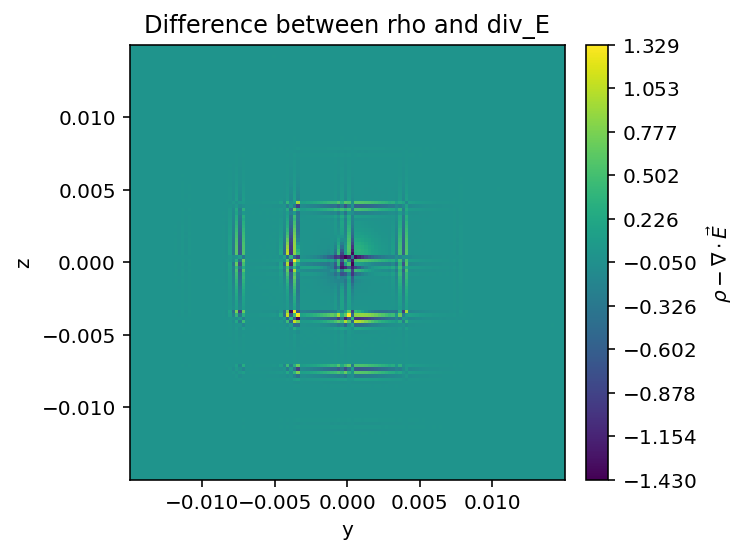

In [51]:
print(f"Trial: {trialfile}")
run_gauss = f"{trialpath}/{trialfile}/gauss.xdmf"
vf_gauss = viscid.load_file(run_gauss, force_reload=True)
print([f.name for f in vf_gauss.iter_fields()])

vf_gauss.activate_time(0)
zoom = .005
vlt.plot(vf_gauss["rho"] - vf_gauss["dive"], cbarlabel="$\\rho-\\nabla\\cdot\\vec E$");
plt.title("Difference between rho and div_E")
# plt.xlim(-zoom, zoom)
# plt.ylim(-zoom, zoom);

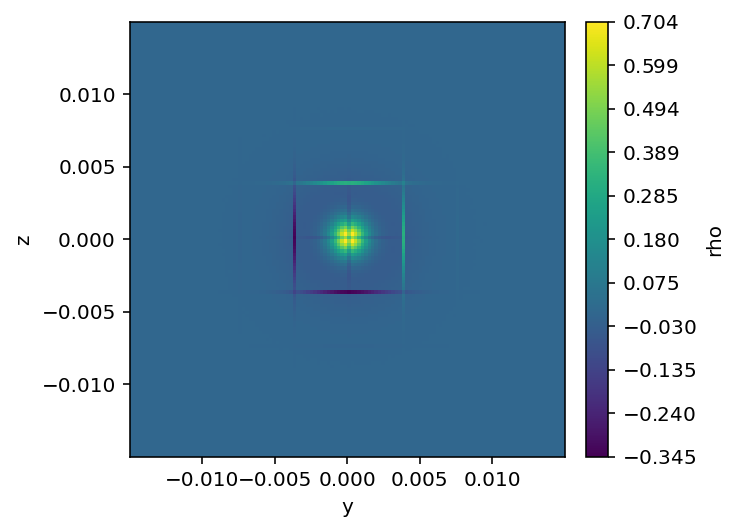

In [48]:
vlt.plot(vf_gauss["rho"]);

## Phi

Trial: .
['phi']


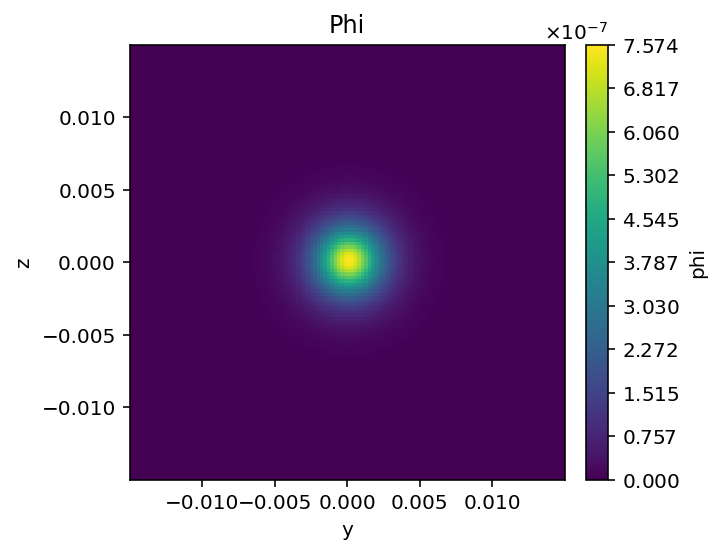

In [53]:
print(f"Trial: {trialfile}")
run_phi = f"{trialpath}/{trialfile}/phi.xdmf"
vf_phi = viscid.load_file(run_phi, force_reload=True)
print([f.name for f in vf_phi.iter_fields()])

vf_phi.activate_time(0)
vlt.plot(vf_phi["phi"]);
plt.title("Phi");

## Grad Phi

Trial: .
['gradx', 'grady', 'gradz']


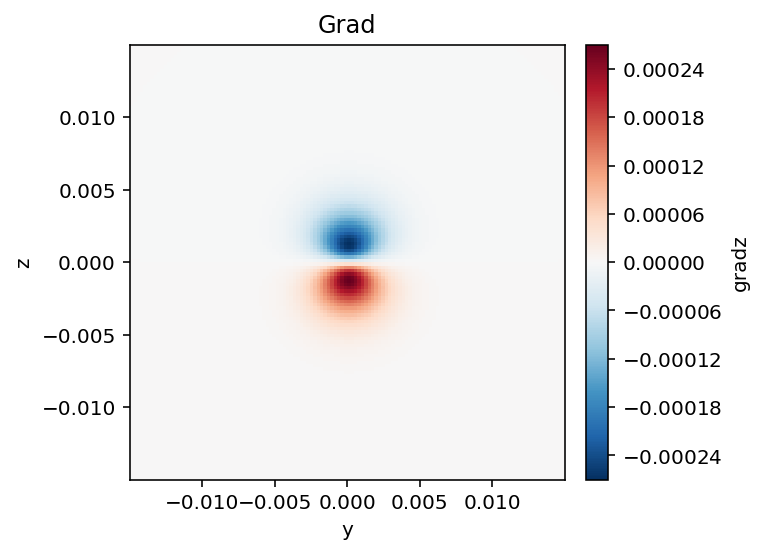

In [54]:
print(f"Trial: {trialfile}")
run_grad = f"{trialpath}/{trialfile}/grad.xdmf"
vf_grad = viscid.load_file(run_grad, force_reload=True)
print([f.name for f in vf_grad.iter_fields()])

vf_grad.activate_time(0)
vlt.plot(vf_grad["gradz"]);
plt.title("Grad");

## Div Grad Phi

Trial: .
['divgrad']


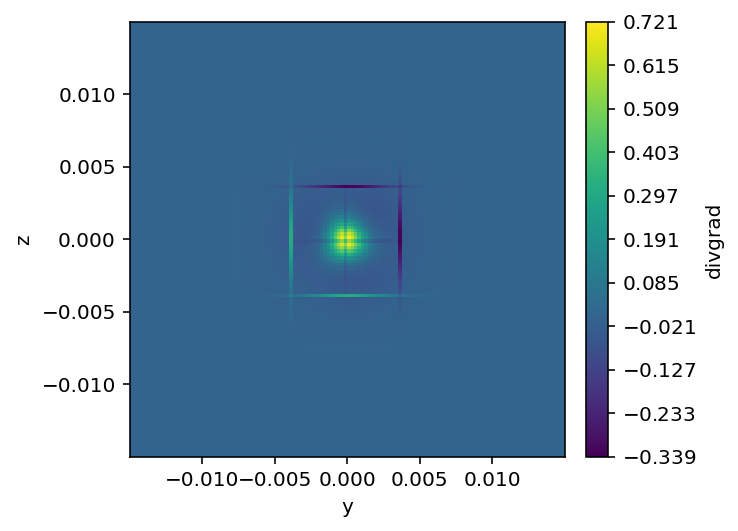

In [56]:
print(f"Trial: {trialfile}")
run_divgrad = f"{trialpath}/{trialfile}/divgrad.xdmf"
vf_divgrad = viscid.load_file(run_divgrad, force_reload=True)
print([f.name for f in vf_divgrad.iter_fields()])

vf_divgrad.activate_time(0)
# vlt.plot(-vf_divgrad["divgrad"], cbarlabel="$-\\nabla^2 \\phi$");
vlt.plot(-vf_divgrad["divgrad"]);


## Checking Gauss

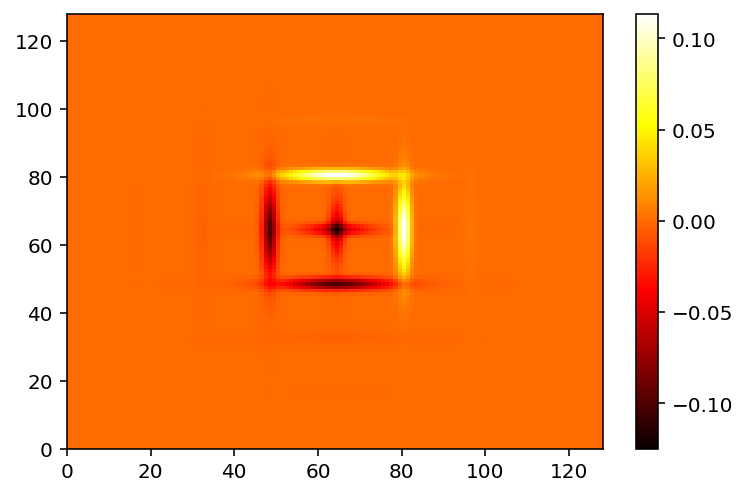

In [45]:
# compare my divgrad to gauss rho or dive
options = [vf.data for vf in [
        vf_gauss["rho"] * 0,                          # [0] zero
        -vf_divgrad["divgrad"],                       # [1] -divgrad
        vf_gauss["rho"],                              # [2] gauss rho
        vf_gauss["dive"],                             # [3] gauss dive
        vf_moments["rho_i"] + vf_moments["rho_e"],    # [4] rho
        vf_moments["rho_i"],                          # [5] rho_i
        -vf_moments["rho_e"]                          # [6] rho_e
    ]]

lhs = options[2]
rhs = options[3]
o = 0

if o == 0:
    data = lhs[0,:,:] - rhs[0,:,:];
elif o > 0:
    data = lhs[0,o:,o:] - rhs[0,:-o,:-o];
elif o < 0:
    data = lhs[0,:o,:o] - rhs[0,-o:,-o:];
    
fig, ax = plt.subplots()
heatmap = ax.pcolormesh(data, cmap="hot")
cbar = plt.colorbar(heatmap)